In [ ]:
!pip install patool

In [ ]:
!pip3 install face_recognition

In [ ]:
!pip install -U keras keras-applications

In [ ]:
!pip install timm

In [ ]:
!pip install explainable-cnn

In [ ]:
import matplotlib
import imageio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import patoolib

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
patoolib.extract_archive('/content/drive/MyDrive/deepfake_datset/Celeb_fake_face_only-20240404T080723Z-001.zip')

In [ ]:

patoolib.extract_archive('/content/drive/MyDrive/deepfake_datset/Celeb_real_face_only-20240404T084023Z-001.zip')
patoolib.extract_archive('/content/drive/MyDrive/deepfake_datset/DFDC_FAKE_Face_only_data-20240404T084149Z-001.zip')
patoolib.extract_archive('/content/drive/MyDrive/deepfake_datset/DFDC_REAL_Face_only_data-20240404T084151Z-001.zip')
patoolib.extract_archive('/content/drive/MyDrive/deepfake_datset/FF_Face_only_data-20240404T084147Z-001.zip')

In [ ]:
import json
import glob
import numpy as np
import cv2
import copy
import random
video_files =  glob.glob('/content/Celeb_fake_face_only/*.mp4')
video_files += glob.glob('/content/Celeb_real_face_only/*.mp4')
video_files += glob.glob('/content/DFDC_FAKE_Face_only_data/*.mp4')
video_files += glob.glob('/content/DFDC_REAL_Face_only_data/*.mp4')
video_files += glob.glob('/content/FF_Face_only_data/*.mp4')
random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 121, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 146, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 100, 148, 148, 148, 104, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 14

In [ ]:
from PIL import ImageChops, ImageEnhance
import PIL.Image
import os
import numpy as np
import cv2


def error_level_analysis(img_path, final_path):

    original = PIL.Image.open(img_path).convert('RGB')
    original = np.array(original)
    original = cv2.resize(original, (1120, 1120))
    original = PIL.Image.fromarray(original)
    original.save("output", 'JPEG', quality=75)
    temporary = PIL.Image.open("output")
    diff = ImageChops.difference(original, temporary)

    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)


    return diff

In [ ]:
#แบบที่ 1 แบบไม่ใช้ error_level_analysis
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
#แบบที่ 2 แบบใช้ error_level_analysis
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageChops, ImageEnhance

class video_dataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100 / self.sequence_length)
        first_frame = np.random.randint(0, a)
        temp_video = os.path.basename(video_path)
        label = self.labels.loc[self.labels["file"] == temp_video, "label"].iloc[0]
        label = 0 if label == 'FAKE' else 1

        frame_count = 0
        for i, frame in enumerate(self.frame_extract(video_path)):
            if i % a == first_frame:
                ela_frame = self.error_level_analysis(frame)
                if self.transform:
                    ela_frame = self.transform(ela_frame)
                frames.append(ela_frame)
                frame_count += 1
            if frame_count == self.sequence_length:
                break

        frames = torch.stack(frames)
        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

    def error_level_analysis(self, frame):
        frame_pil = PIL.Image.fromarray(frame)
        frame_pil.save("temp_frame.jpg", 'JPEG', quality=75)
        temporary = PIL.Image.open("temp_frame.jpg")
        diff = ImageChops.difference(frame_pil, temporary)
        extrema = diff.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        scale = 255.0 / max_diff
        diff = ImageEnhance.Brightness(diff).enhance(scale)
        diff_np = np.array(diff)
        #diff_tensor = torch.from_numpy(diff_np).permute(2, 0, 1).float()

        return diff_np

# plot the image

def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()


In [ ]:
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/MyDrive/deepfake_datset/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake


# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/MyDrive/deepfake_datset/Gobal_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8 * len(video_files))]
valid_videos = video_files[int(0.85 * len(video_files)):]
#test_videos = video_files[int(0.95 * len(video_files)):]

print("train : " , len(train_videos))
print("VALID : " , len(valid_videos))
#print('test::',len(test_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

#print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
#print("VALID: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])
#print("TEST: ", "Real:",number_of_real_and_fake_videos(test_videos)[0]," Fake:",number_of_real_and_fake_videos(test_videos)[1])



train :  5141
VALID :  965


torch.Size([20, 3, 224, 224])


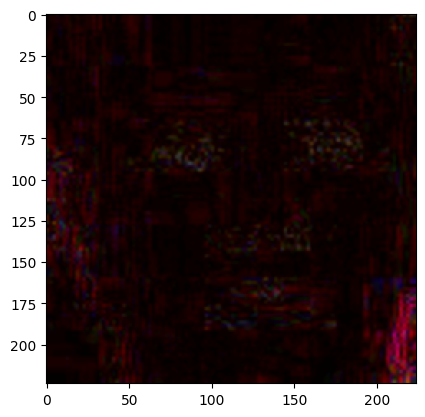

In [ ]:
import random
im_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms =  transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
    ])
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
  ])
train_data = video_dataset(train_videos,labels,sequence_length = 20,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 20,transform = train_transforms)
##test_data = video_dataset(test_videos,labels,sequence_length=20,transform= test_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,pin_memory=False, num_workers=4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = False,num_workers = 4)
#test_loader = DataLoader(test_data,batch_size=4,shuffle=False,num_workers=4)

n = random.randint(5,35)
image,label = train_data[n]
print(image.shape)
im_plot(image[0,:,:,:])

In [ ]:
for i in range(10):
  n = random.randint(5,35)
  image,label = train_data[n]
  print(image.shape)
  im_plot(image[0,:,:,:])

In [ ]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)


In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from tqdm import tqdm
import time
import copy

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
class_categories = datasets.ImageFolder(os.path.join('/content/drive/MyDrive/deepfake_datset/TrainandValid/', 'training/')).classes
# ['Covid', 'Normal', 'Viral Pneumonia']
num_classes = len(class_categories)
num_classes

2

In [ ]:
import torch
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 1280, lstm_layers=1 , hidden_dim = 1280, bidirectional = False):
        super(Model, self).__init__()
        model = models.efficientnet_b0(pretrained=True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(1280,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,1280)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((4,10,3,224,224))).type(torch.cuda.FloatTensor))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 177MB/s]


In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint100frame.pt')
    return losses.avg,accuracies.avg


In [ ]:
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 2

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.99 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.07 GiB is free. Process 2293 has 13.67 GiB memory in use. Of the allocated memory 13.47 GiB is allocated by PyTorch, and 69.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()


In [ ]:
im_size = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('/content/1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  return [int(prediction.item()),confidence]
#img = train_data[100][0].unsqueeze(0)
#predict(model,img)

In [ ]:
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]

        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
im_size = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255)),
  ])
path_to_videos = ['/content/drive/My Drive/Balanced_Face_only_data/aagfhgtpmv.mp4',
                                   '/content/drive/My Drive/Balanced_Face_only_data/aczrgyricp.mp4',
                                   '/content/drive/My Drive/Balanced_Face_only_data/agdkmztvby.mp4',
                                   '/content/drive/My Drive/Balanced_Face_only_data/abarnvbtwb.mp4']

path_to_videos = ['/content/drive/My Drive/Youtube_Face_only_data/000_003.mp4',
                  '/content/drive/My Drive/Youtube_Face_only_data/000.mp4',
                  '/content/drive/My Drive/Youtube_Face_only_data/002_006.mp4',
                  '/content/drive/My Drive/Youtube_Face_only_data/002.mp4'


]

path_to_videos1= ["/content/face_changed_video_v3.mp4"]

video_dataset = validation_dataset(path_to_videos1,sequence_length = 50,transform = test_transforms1)
model = Model(2).cuda()
path_to_model = '/content/checkpoint20frame.pt'
model.load_state_dict(torch.load(path_to_model))
model.eval()
for i in range(0,len(path_to_videos)):
  print(path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1:
    print("REAL")
  else:
    print("FAKE")

/content/drive/My Drive/Youtube_Face_only_data/000_003.mp4
